In [1]:
from lmfit.models import LorentzianModel, ConstantModel
from init import *
sns.set_theme(rc={
    # "figure.dpi": 100, 
    "figure.figsize": (8, 6)
    })

def hamil(
        mw_det,
        b_longitudinal=0.1,
        mw_mag_field=1e-2,
        laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/5):

    # Atom-field Hamiltonian
    # sigma_plus
    ham_laser_atom = H_atom_field_D1(-1, E_0_plus(laser_intens)).full()
    # ham_laser_atom[8:11, :] = 0
    # ham_laser_atom[:, 8:11] = 0
    ham_laser_atom[:3, :] = 0       # F=1 -> F' neglected
    ham_laser_atom[:, :3] = 0
    # Hyperfine Structure with Zeeman levels
    hb0 = H_hfs_ground() + H_B(bz=b_longitudinal)
    eigvals, eigstates = hb0.eigenstates()
    F_states_reordered = [
        eigstates[2],
        eigstates[1],
        eigstates[0],
    ]
    for k in range(3, 3 + 5):
        F_states_reordered.append(eigstates[k])
    # Atom Hamiltonian in rotating frame
    ham_atom = H_atom(det_Light=0, line="D1").full()
    ham_atom[:8, :8] = hb0.transform(F_states_reordered).tidyup(atol=1e-3)
    ham_atom[8:, 8:] = hb0.transform(F_states_reordered).tidyup(
        atol=1e-3)/3   # for excited state: g'_F = g_F / 3
    diff_f2_fp1 = ham_atom[9, 9] - ham_atom[5, 5]
    for k in range(8, 16):
        # laser resonant to F=2 m_F=0 to F'=1, m'_F=0
        ham_atom[k, k] -= diff_f2_fp1

    diff_f2_f1 = (ham_atom[5, 5]-ham_atom[1, 1])
    for k in range(3):
        ham_atom[k, k] += diff_f2_f1  # rotating frame mw

    # for k in range(8, 11):
    #     ham_atom[k, k] = 0      # we ignore F'=1
    # for k in range(11, 16):
    #     # laser resonant to all Zeeman levels
    #     ham_atom[k, k] = ham_atom[k-8, k-8]
    hb_ac = H_B(bx=mw_mag_field/2**0.5, by=mw_mag_field/2 **
                0.5).transform(F_states_reordered).tidyup(atol=1e-3)  # transverse MW field
    hb_ac = hb_ac.full()
    for i in range(7):  # RWA
        hb_ac[i, i + 1] = 0.0
        hb_ac[i + 1, i] = 0.0
    h_a_mw = np.zeros(shape=(16, 16), dtype=np.cdouble)
    h_a_mw[:8, :8] = hb_ac

    ham_tot = ham_atom + h_a_mw + ham_laser_atom
    for k in range(3):
        ham_tot[k, k] += mw_det
    offset = ham_tot[1, 1]
    for k in range(16):
        ham_tot[k, k] -= offset
    return Qobj(ham_tot).tidyup(atol=1e-3)


def faraday_rot_angle(rho):
    wavelength_probe_laser = 780e-9
    density_atoms = 2.33e12 / (1e-2)**3
    length_cell = 2e-3
    detuning_probe = -30e9 * 2*pi
    return (
        sum([mF * (-1)**F * rho.matrix_element(get_ket_Fg_D1(F, mF).dag(), get_ket_Fg_D1(F, mF))
            for F in (1, 2) for mF in range(-F, F + 1)]).real
        * density_atoms*length_cell
        * wavelength_probe_laser**2
        * GAMMA_RAD_D2
        / detuning_probe
        * 0.5
    )

In [1]:
decays = (
    natural_decay_ops_D1() 
    + quenching_ops("D1") 
    + wall_coll("D1", gamma=5e3)
    + dephasing_excited_states("D1", gamma=1e7)
)
laser_intens = OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/10
b_longitudinal = 0.1
Bmw = 5e-5
ham_tot = hamil(0, b_longitudinal=b_longitudinal,
                laser_intens=laser_intens, mw_mag_field=Bmw)
laser_ss = steadystate(
    hamil(0, b_longitudinal=b_longitudinal,
          laser_intens=laser_intens, mw_mag_field=0),
    c_op_list=decays
)
mw_detunings = np.linspace(ham_tot[3, 3] - ham_tot[0, 0] - 500e3*2*pi,
                           ham_tot[7, 7] - ham_tot[2, 2] + 500e3*2*pi,
                           201)
time_evo_options = Options(nsteps=2**5 * 1000)

NameError: name 'natural_decay_ops_D1' is not defined

In [5]:
h = hamil(ham_tot[3, 3] - ham_tot[0, 0],
          b_longitudinal, laser_intens=laser_intens, mw_mag_field=Bmw)
res = mesolve(
    h,
    rho0=laser_ss,
    tlist=np.linspace(0, 1e-3, 5000),
    c_ops=decays,
    options=time_evo_options,
    progress_bar=True
)
plot_excited_states_time(res)
plot_ground_states_time(res)

10.0%. Run time:  25.28s. Est. time left: 00:00:03:47
20.0%. Run time:  50.93s. Est. time left: 00:00:03:23
30.0%. Run time:  76.66s. Est. time left: 00:00:02:58
40.0%. Run time: 101.98s. Est. time left: 00:00:02:32
50.0%. Run time: 129.13s. Est. time left: 00:00:02:09
60.0%. Run time: 154.82s. Est. time left: 00:00:01:43
70.0%. Run time: 181.22s. Est. time left: 00:00:01:17
80.0%. Run time: 206.53s. Est. time left: 00:00:00:51


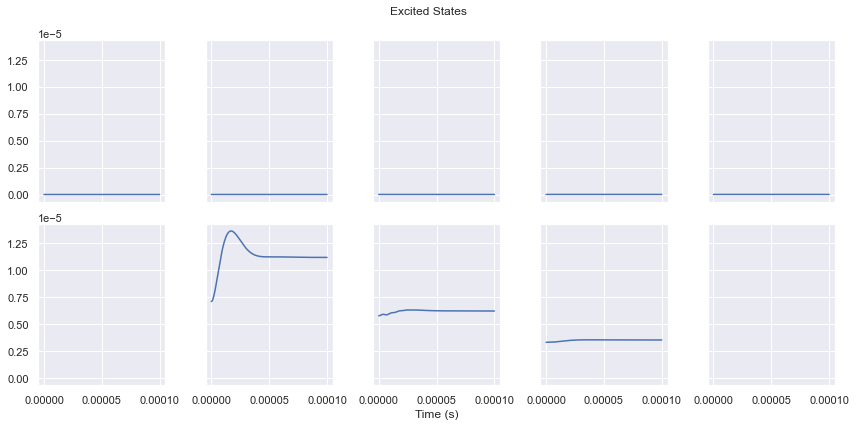

In [13]:
# plot_excited_states_time(res)
# plt.savefig("time_evo_transition_1.png")


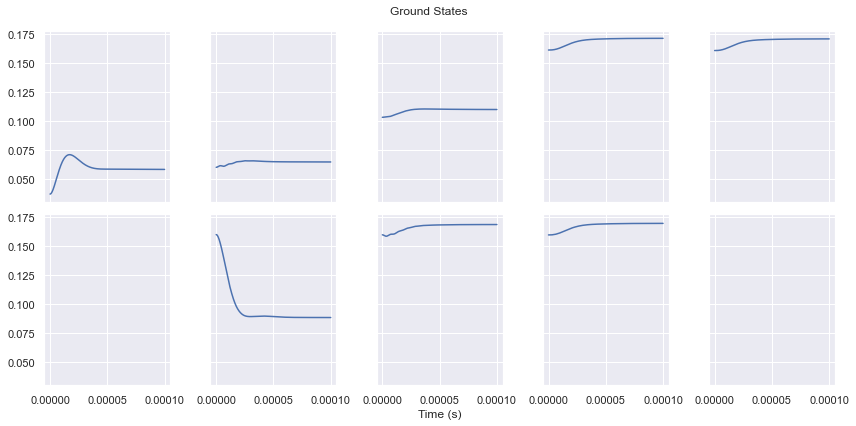

In [14]:
# plot_ground_states_time(res)
# plt.savefig("time_evo_transition_1_ground.png")


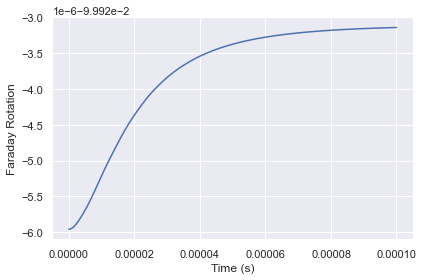

In [42]:
thetas = [faraday_rot_angle(state) for state in res.states]
plt.plot(np.linspace(0, 1e-4, 5000), thetas)
plt.xlabel("Time (s)")
plt.ylabel("Faraday Rotation")
plt.tight_layout()
# plt.savefig("faraday rot time evo.png")

(0.0, 10000.0)

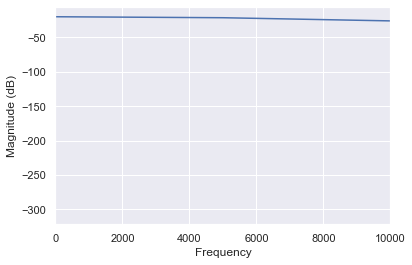

In [43]:
plt.magnitude_spectrum(thetas, Fs=5e7, pad_to=10000, scale="dB")
plt.xlim(0, 1e4)

10.0%. Run time:   2.87s. Est. time left: 00:00:00:25
20.0%. Run time:   5.59s. Est. time left: 00:00:00:22
30.0%. Run time:   8.13s. Est. time left: 00:00:00:18
40.0%. Run time:  10.82s. Est. time left: 00:00:00:16
50.0%. Run time:  13.65s. Est. time left: 00:00:00:13
60.0%. Run time:  16.34s. Est. time left: 00:00:00:10
70.0%. Run time:  19.32s. Est. time left: 00:00:00:08
80.0%. Run time:  22.20s. Est. time left: 00:00:00:05
90.0%. Run time:  25.02s. Est. time left: 00:00:00:02
Total run time:  27.83s


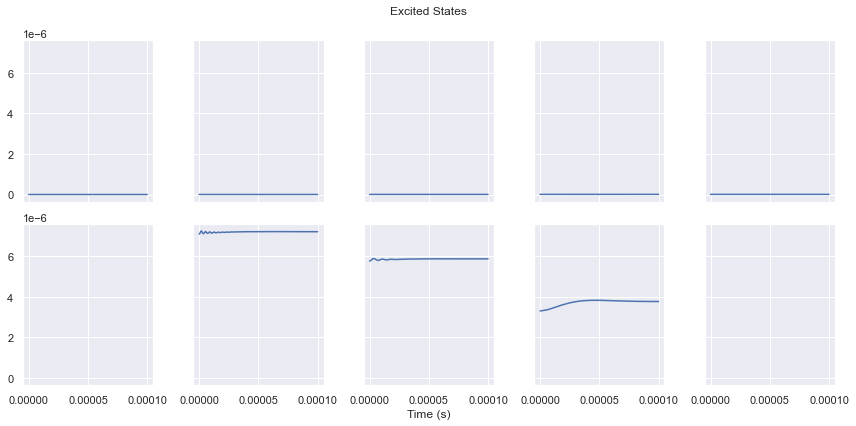

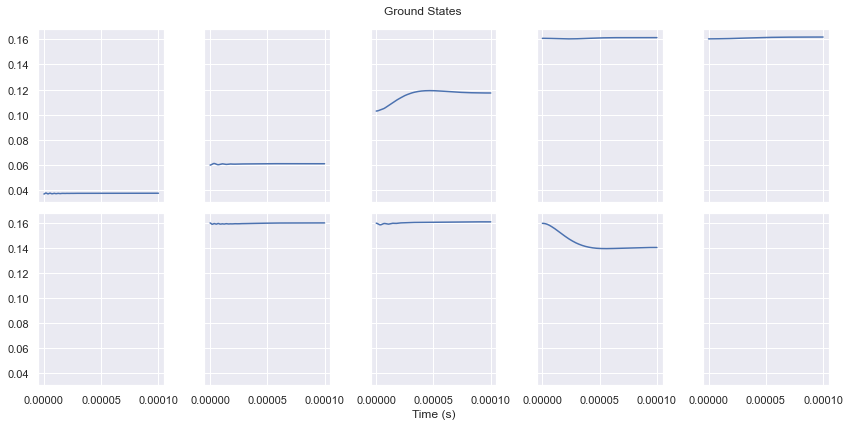

In [18]:
h = hamil(ham_tot[6, 6] - ham_tot[1, 1],
          b_longitudinal, laser_intens=laser_intens, mw_mag_field=Bmw)
res = mesolve(
    h,
    rho0=laser_ss,
    tlist=np.linspace(0, 1e-4, 5000),
    c_ops=decays,
    options=time_evo_options,
    progress_bar=True
)
plot_excited_states_time(res)
plot_ground_states_time(res)


In [ ]:
sum(res.states[-1].diag()[:8])

In [ ]:
# plot_excited_states_time(res)
# plt.savefig("time_evo_transition_5_excited.png")
# plot_ground_states_time(res)
# plt.savefig("time_evo_transition_5_ground.png")

## strong MW

In [49]:
Bmw = 5e-2
laser_intens = OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/10
b_longitudinal = 0.1
ham_tot = hamil(0, b_longitudinal=b_longitudinal,
                laser_intens=laser_intens, mw_mag_field=Bmw)
laser_ss = steadystate(
    hamil(0, b_longitudinal=b_longitudinal,
          laser_intens=laser_intens, mw_mag_field=0),
    c_op_list=decays
)
mw_detunings = np.linspace(ham_tot[3, 3] - ham_tot[0, 0] - 500e3*2*pi,
                           ham_tot[7, 7] - ham_tot[2, 2] + 500e3*2*pi,
                           201)
time_evo_options = Options(nsteps=2**5 * 1000)


In [50]:
ham_tot[:3, 3:8]

array([[ 269706.69412466-269706.69412466j,
              0.             +0.j        ,
        -110114.06815388-110114.06815388j,
              0.             +0.j        ,
              0.             +0.j        ],
       [      0.             +0.j        ,
        -190707.52039507+190707.52039507j,
              0.             +0.j        ,
         190719.24847833+190719.24847833j,
              0.             +0.j        ],
       [      0.             +0.j        ,
              0.             +0.j        ,
        -110102.77980909+110102.77980909j,
              0.             +0.j        ,
         269712.21546871+269712.21546871j]])

In [51]:
hamil(0, b_longitudinal=b_longitudinal,
                laser_intens=laser_intens, mw_mag_field=Bmw)[:8, 8:]

array([[      0.        +0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j],
       [      0.        +0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j],
       [      0.        +0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j],
       [4947165.92069761+0.j,       0.        +0.j,       0.        +0.j,
              0.        +0.j, 2856247.57604051+0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j],
       [      0.        +0.j, 3498174.57018027+0.j,       0.        +0.j,
              0.        +0.j,       0.        +0.j, 3498174.57018027+0.j,
              0.        +0.j,       0.        +0

10.0%. Run time:   5.20s. Est. time left: 00:00:00:46
20.0%. Run time:  10.10s. Est. time left: 00:00:00:40
30.0%. Run time:  14.99s. Est. time left: 00:00:00:34
40.0%. Run time:  19.94s. Est. time left: 00:00:00:29
50.0%. Run time:  25.06s. Est. time left: 00:00:00:25
60.0%. Run time:  30.54s. Est. time left: 00:00:00:20
70.0%. Run time:  35.47s. Est. time left: 00:00:00:15
80.0%. Run time:  40.35s. Est. time left: 00:00:00:10
90.0%. Run time:  45.24s. Est. time left: 00:00:00:05
Total run time:  50.50s


(<Figure size 864x432 with 10 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='Time (s)'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

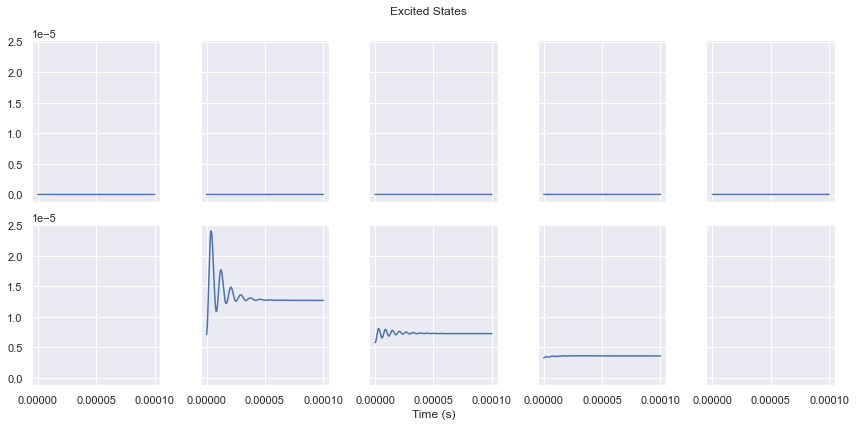

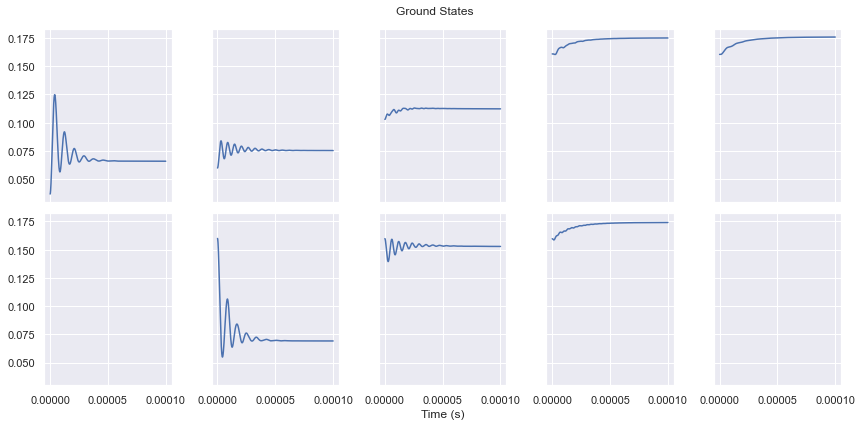

In [52]:
h = hamil(ham_tot[3, 3] - ham_tot[0, 0],
          b_longitudinal, laser_intens=laser_intens, mw_mag_field=Bmw)
res = mesolve(
    h,
    rho0=laser_ss,
    tlist=np.linspace(0, 1e-4, 5000),
    c_ops=decays,
    options=time_evo_options,
    progress_bar=True
)
plot_excited_states_time(res)
plot_ground_states_time(res)

In [53]:
def faraday_rot_angle(rho):
    wavelength_probe_laser = 780e-9
    density_atoms = 2.33e12 / (1e-2)**3
    length_cell = 2e-3
    detuning_probe = -30e9 * 2*pi
    return (
        sum([mF * (-1)**F * rho.matrix_element(get_ket_Fg_D1(F, mF).dag(), get_ket_Fg_D1(F, mF))
            for F in (1, 2) for mF in range(-F, F + 1)]).real
        * density_atoms*length_cell
        * wavelength_probe_laser**2
        * GAMMA_RAD_D2
        / detuning_probe
        * 0.5
    )

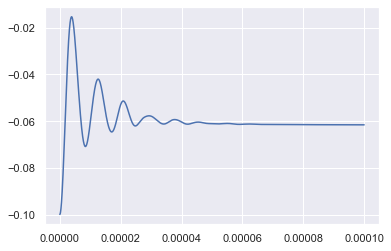

In [54]:
thetas = [faraday_rot_angle(state) for state in res.states]
plt.plot(np.linspace(0, 1e-4, 5000), thetas)

In [56]:
1/(1e-4/5000)

50000000.0

(0.0, 500000.0)

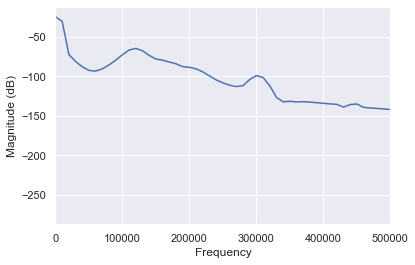

In [57]:
plt.magnitude_spectrum(thetas, Fs=5e7, scale="dB")
plt.xlim(0, 5e5)